# Setting Up

## Conexión a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd ./drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

## Importar los módulos *_utils

In [4]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

# Funciones locales

## fcNeuralNetworkModel()

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def fcNeuralNetworkModel(task, params, optimizer, verbose = False):
    """
    Defines and compiles a new Keras model for a Fully Connected Neural Network
    with 1 hidden layer (a total of 3 layers) and dropout regularization.
    The number of units per layer, the activation function, the regularization 
    rate and the are given by the params dictionary.

    """
    VEC_EMBEDDINGS_DIM = 300
    activation_f = params['activation']

    input_vector = keras.Input(name='INPUT', shape=(VEC_EMBEDDINGS_DIM), dtype="float64")

    x  = layers.Dense(units=params['L1_size'], 
                              activation=activation_f, 
                              name = 'DL_1')(input_vector)

    x = layers.Dropout(rate=params['p_dropout_1'], name = 'DROPOUT_1')(x)                              

    x = layers.Dense(units=params['L2_size'], 
                              activation=activation_f, 
                              name = 'DL_2')(x)                          

    x = layers.Dropout(rate=params['p_dropout_2'], name = 'DROPOUT_2')(x)

    if task in ['HS', 'TR', 'AG']:
      preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(x)
      model = keras.Model(input_vector, preds)

      model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

    elif task == 'HTA':
      preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(x)
      preds = reshape = layers.Reshape(target_shape=(5,))(preds)

      model = keras.Model(input_vector, preds)
      model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

    if verbose:
      model.summary()

    return model

## Dataset

In [6]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='SINGLE-VEC',
                                                 labels_to_return=['AG'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)


# EXPERIMENTOS

# Búsqueda número 1

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

arch_params_dict = {
    'L1_size': [400, 300, 200],                    
    'L2_size': [150, 100, 75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.5],
    'p_dropout_2':[0.5]                                
}

arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

9 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


18 trainig_params_combos.


**Combinaciones (arquitectura) x (entrenamiento)**

In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


162 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          fcNeuralNetworkModel, 
                          search_space[:90],
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/SNN/HS/experiments_1_1.df',
                          backup_freq=25,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
results_list = ['./Results/SNN/HS/experiments_1_1.df',
                './Results/SNN/HS/experiments_1_2.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/SNN/HS/experiments_1.df') 

In [ ]:
import pickle
with open('./Results/SNN/HS/experiments_1.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
75,hFwTgWXg,300,100,relu,0.5,0.5,adam-5e-4,256,75,40,0.733302,0.735395,38,61,0.750976,0.744843
33,KxOOBcUS,400,100,relu,0.5,0.5,rmsprop-1e-4,256,75,34,0.713002,0.735388,34,42,0.723035,0.741690
21,LduomEJM,400,100,relu,0.5,0.5,adam-5e-4,256,75,44,0.754127,0.735041,21,53,0.712358,0.740642
57,aUCslGzE,300,150,relu,0.5,0.5,adam-5e-4,256,75,35,0.734877,0.733642,27,45,0.732717,0.742745
50,nqsYfPop,400,75,relu,0.5,0.5,rmsprop-5e-4,1024,75,55,0.689551,0.733291,55,71,0.696609,0.740994


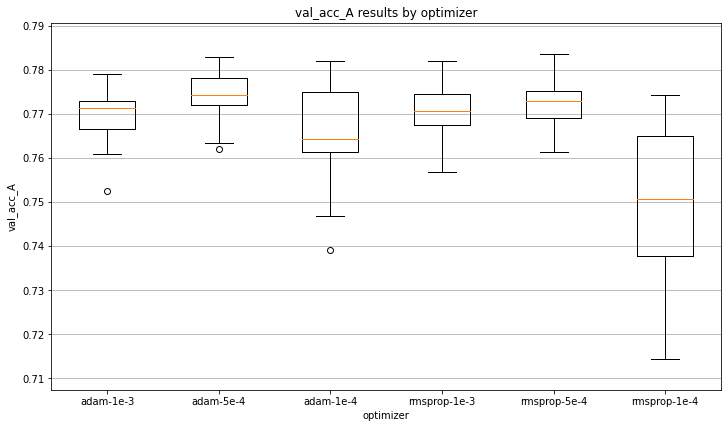

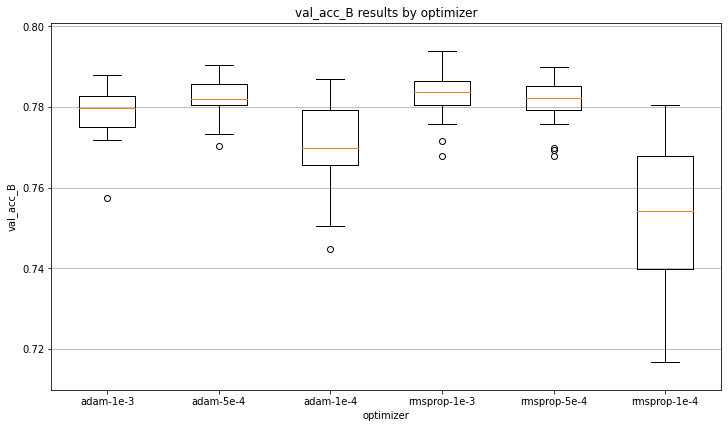

In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']                                
}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

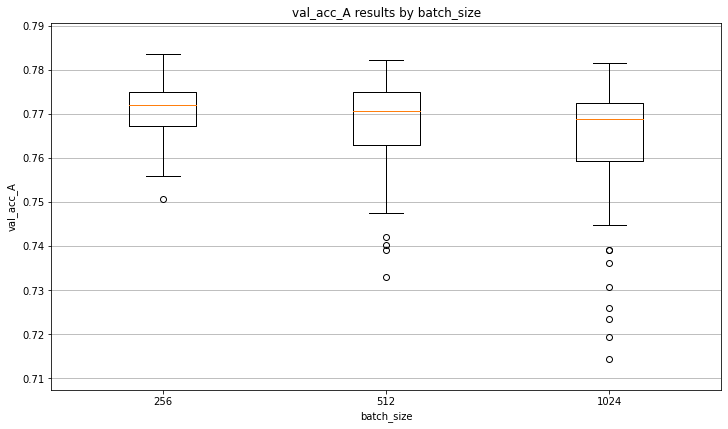

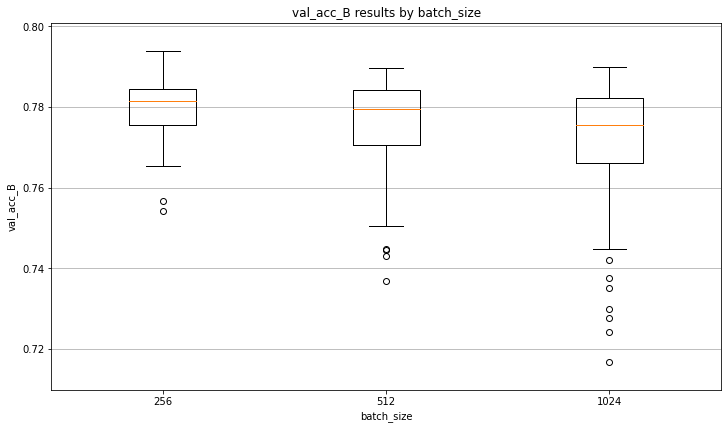

In [ ]:
results_utils.plotResultsByParameter1(results_df, 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* optimizador: ['adam-1e-3','adam-5e-4'], ['adam-1e-4','rmsprop-5e-4']
* batch_size [256,512]

# Búsqueda número 2

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

arch_params_dict = {
    'L1_size': [500, 400, 300, 200],                    
    'L2_size': [200, 150, 100, 75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5,0.75],
    'p_dropout_2':[0.25,0.5,0.75]                                
}

arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

96 arch_params_combos.


**Parámetros de entrenamiento**

In [ ]:
trainig_params = {'optimizer':['adam-5e-4', 'rmsprop-5e-4'],
                    'batch_size':[256],
                    'max_epochs':[75]}
                        
trainig_params_combos = list(product( *trainig_params.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos)))


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


192 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          fcNeuralNetworkModel, 
                          search_space[:95],
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/SNN/HS/experiments_2_1.df',
                          backup_freq=25,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/SNN/HS/experiments_2_1.df
SCANNING SEARCH SPACE

95 configurations will be evaluated.
1  - conf_ID: LKpHtNgX   ****  --  train_acc_A = 0.743,  val_acc_A = 0.774    --  train_acc_B = 0.764,  val_acc_B = 0.78    
2  - conf_ID: QzhXotYH   ****  --  train_acc_A = 0.794,  val_acc_A = 0.77     --  train_acc_B = 0.814,  val_acc_B = 0.782   
3  - conf_ID: oDhegpbw   ****  --  train_acc_A = 0.781,  val_acc_A = 0.778    --  train_acc_B = 0.797,  val_acc_B = 0.785   
4  - conf_ID: tyTJhjTv   ****  --  train_acc_A = 0.781,  val_acc_A = 0.772    --  train_acc_B = 0.778,  val_acc_B = 0.783   
5  - conf_ID: nRbgIPBY   ****  --  train_acc_A = 0.786,  val_acc_A = 0.774    --  train_acc_B = 0.778,  val_acc_B = 0.783   
6  - conf_ID: uxJKEzMl   ****  --  train_acc_A = 0.718,  val_acc_A = 0.767    --  train_acc_B = 0.77,   val_acc_B = 0.783   
7  - conf_ID: IninOArN   ****  --  train_acc_A = 0.755,  val_acc_A = 0.77     --  train_acc_B = 0.735,  val_acc_B = 0.778   
8  - conf_ID: DYM

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head(5)

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
90,vBuAbLvC,400,75,relu,0.75,0.25,adam-5e-4,256,75,65,0.725952,0.738539,58,70,0.726885,0.742040
86,stzSDXGW,400,75,relu,0.50,0.25,adam-5e-4,256,75,33,0.726536,0.738190,24,61,0.742226,0.740291
26,jHuCrbhB,500,100,relu,0.50,0.25,adam-5e-4,256,75,25,0.703552,0.733992,12,54,0.728164,0.743442
137,iJdkgsov,300,75,relu,0.50,0.50,adam-5e-4,512,75,72,0.775186,0.733292,50,64,0.734118,0.742041
29,LGxgjEhS,500,100,relu,0.50,0.50,adam-5e-4,512,75,45,0.724435,0.733289,32,68,0.737910,0.743793


## Resultados

In [ ]:
results_list = ['./Results/SNN/HS/experiments_2_1.df',
                './Results/SNN/HS/experiments_2_2.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/SNN/HS/experiments_2.df') 

In [ ]:
import pickle
with open('./Results/SNN/HS/experiments_2.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
params_dict = {
    'L1_size': [500, 400, 300, 200],                    
    'L2_size': [200, 150, 100, 75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5,0.75],
    'p_dropout_2':[0.25,0.5,0.75]                                
}

**Resultados por parámetro**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


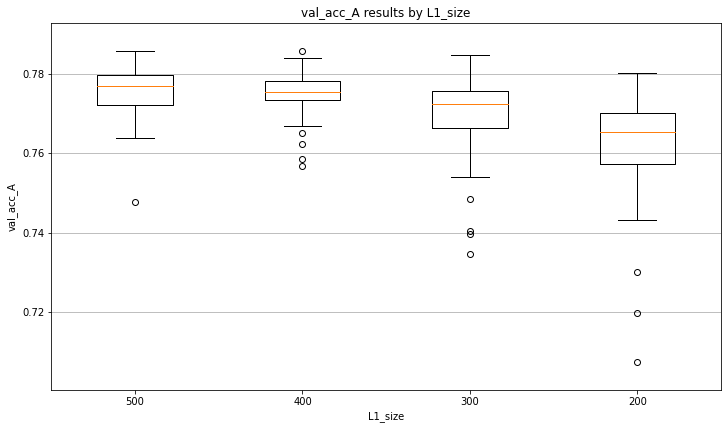

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


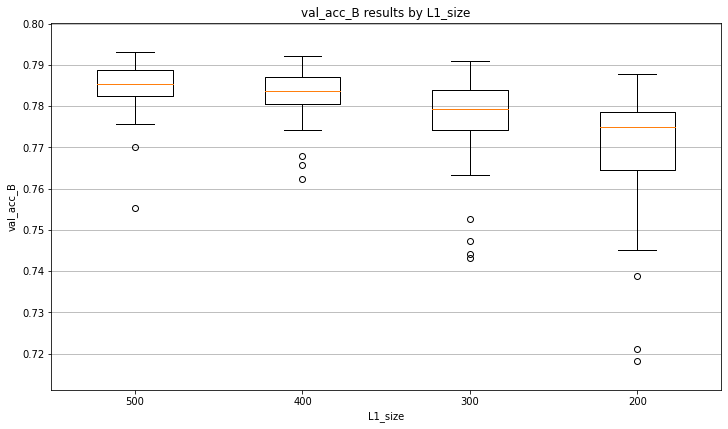

In [ ]:
results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_B')

**L1_size >= 400**

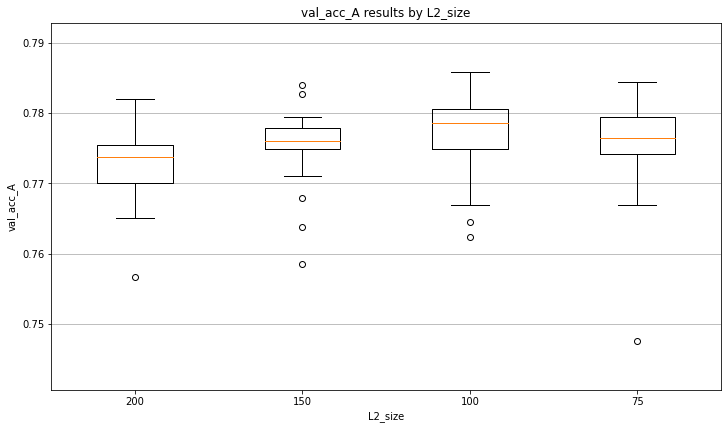

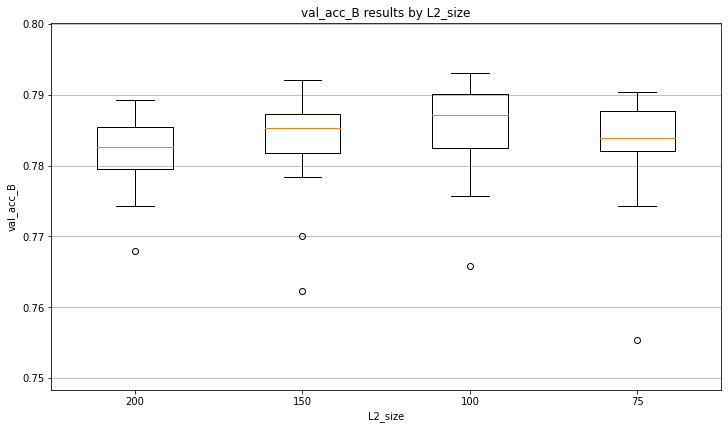

In [ ]:
L1_mask = results_df['L1_size']>= 400
results_subset = results_df.loc[L1_mask]

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_B')

**L2_size <= 100**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


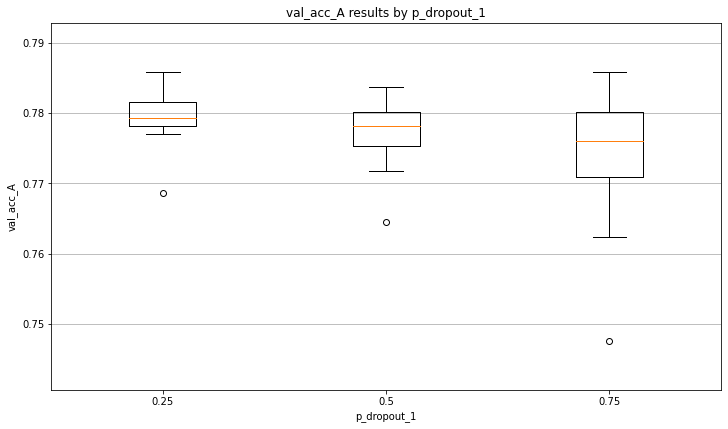

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


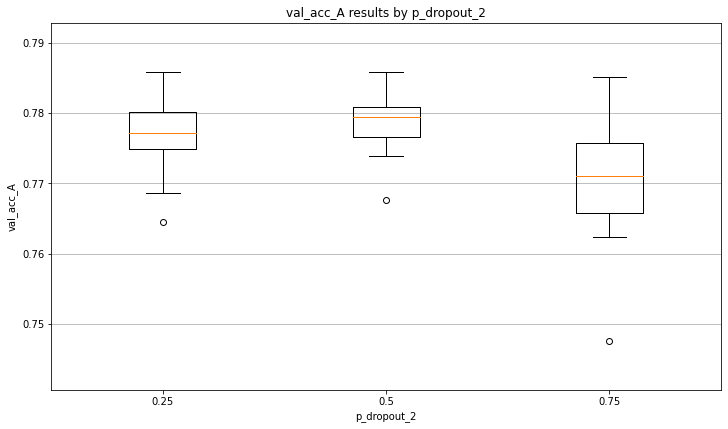

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


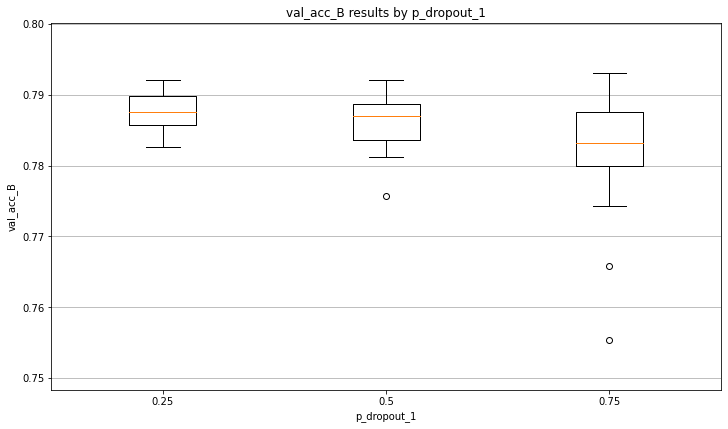

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


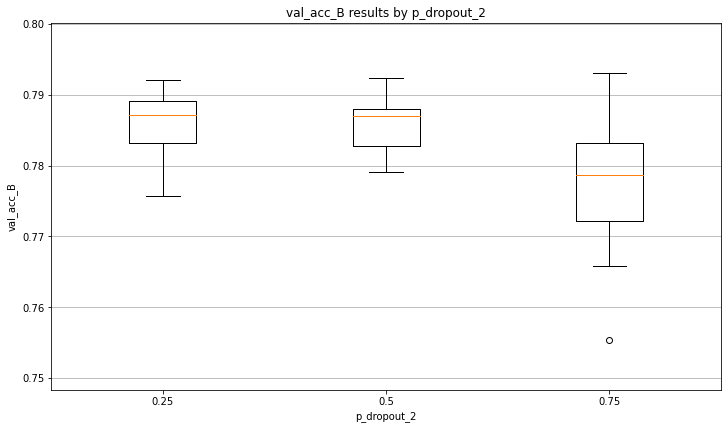

In [ ]:
L1_mask = results_df['L1_size']>= 400
L2_mask = results_df['L2_size']<= 100

results_subset = results_df.loc[L1_mask & L2_mask]

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['p_dropout_1', 'p_dropout_2'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['p_dropout_1', 'p_dropout_2'],
                       metric='val_acc_B')

### Resumen de los resultados
* L1_size >= 400
* L2_size <= 100
* p_dropout_1 = [0.5]
* p_dropout_2 = [0.5,**0.25**]


* optimizador: ['adam-1e-3','adam-5e-4'], ['adam-1e-4','rmsprop-5e-4']
* batch_size [256,512]

# Búsqueda número 3

### Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

arch_params_dict = {
    'L1_size': [550,500,450,400],                    
    'L2_size': [125,100,75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5],
    'p_dropout_2':[0.25,0.5]                                
}

arch_params_keys = arch_params_dict.keys()
arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

36 arch_params_combos.


**Parámetros de entrenamiento**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4', 'rmsprop-5e-4'],
                    'batch_size':[256],
                    'max_epochs':[75]}
                        
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos)))


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


### Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          fcNeuralNetworkModel, 
                          search_space[:],
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/SNN/AG/experiments_3.df',
                          backup_freq=25,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
results_list = ['./Results/SNN/HS/experiments_3_1.df',
                './Results/SNN/HS/experiments_3_2.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/SNN/HS/experiments_3.df') 

In [7]:
import pickle
with open('./Results/SNN/AG/experiments_3.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
17,ySIAWwYR,550,75,relu,0.50,0.50,rmsprop-5e-4,256,75,40,0.801668,0.793492,30,64,37.0,0.811292,0.802945
49,WdNnmVTx,450,75,relu,0.25,0.25,rmsprop-5e-4,256,75,18,0.775302,0.792439,18,47,35.5,0.837831,0.799092
5,JelVIcMU,550,125,relu,0.50,0.50,rmsprop-5e-4,256,75,38,0.815493,0.792088,32,44,36.5,0.815784,0.796640
11,VNgcMqpK,550,100,relu,0.50,0.50,rmsprop-5e-4,256,75,32,0.782360,0.791390,28,32,30.5,0.776877,0.795242
23,GYIRIXdS,500,125,relu,0.50,0.50,rmsprop-5e-4,256,75,35,0.801494,0.790690,22,42,36.5,0.801494,0.800844


In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
37,ujTxMgcx,450,125,relu,0.25,0.25,rmsprop-5e-4,256,75,34,0.860760,0.783341,12,47,21.0,0.816482,0.803996
17,ySIAWwYR,550,75,relu,0.50,0.50,rmsprop-5e-4,256,75,40,0.801668,0.793492,30,64,37.0,0.811292,0.802945
23,GYIRIXdS,500,125,relu,0.50,0.50,rmsprop-5e-4,256,75,35,0.801494,0.790690,22,42,36.5,0.801494,0.800844
47,MFoZEMyN,450,100,relu,0.50,0.50,rmsprop-5e-4,256,75,23,0.753543,0.789644,23,37,30.5,0.783875,0.799094
49,WdNnmVTx,450,75,relu,0.25,0.25,rmsprop-5e-4,256,75,18,0.775302,0.792439,18,47,35.5,0.837831,0.799092


In [8]:
params_dict = {
    'L1_size': [550,500,450,400],                    
    'L2_size': [125,100,75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5],
    'p_dropout_2':[0.25,0.5]                                
}

**Resultados por parámetro**

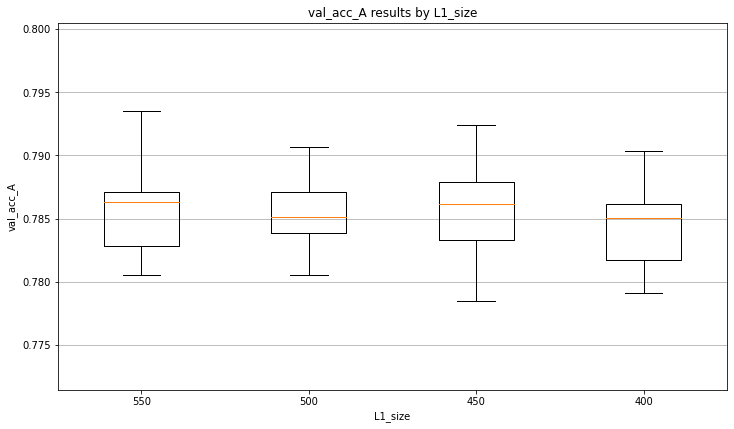

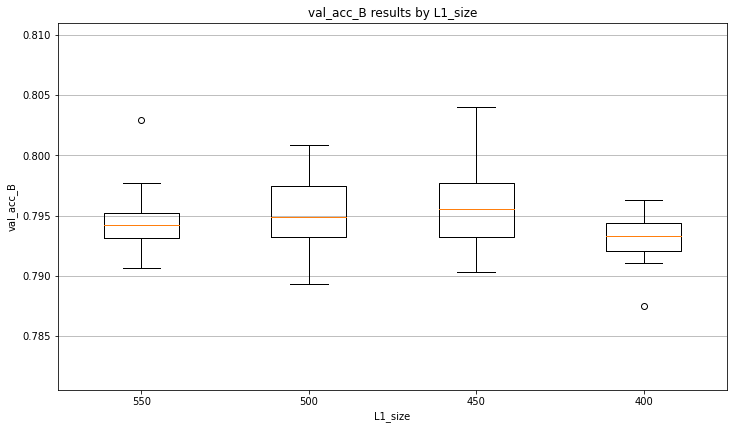

In [9]:
results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_B')

**L1_size >= 400**

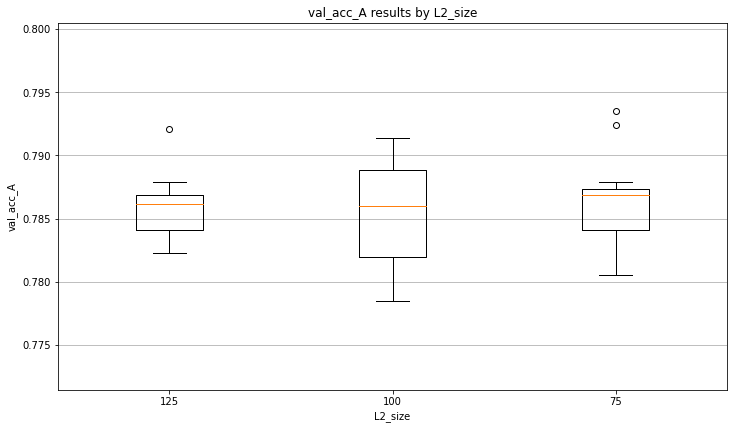

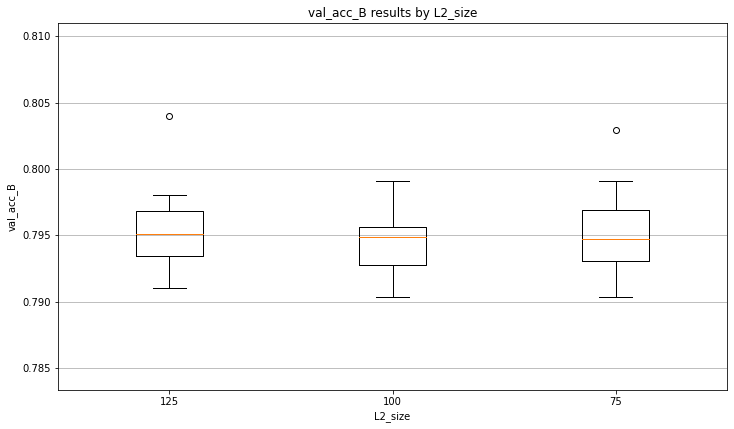

In [10]:
L1_mask = results_df['L1_size'].isin([450,550])
results_subset = results_df.loc[L1_mask]

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_B')

### Resumen de los resultados
* L1_size = [400,550]
* L2_size = [100,75]
* p_dropout_1 = [0.5]
* p_dropout_2 = [0.5,**0.25**]


* optimizador: ['adam-1e-3','adam-5e-4'], ['adam-1e-4','rmsprop-5e-4']
* batch_size [256,512]

# Búsqueda número 4

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [11]:
from itertools import product

arch_params_dict = {
    'L1_size': [550,450],                    
    'L2_size': [125,100],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5],
    'p_dropout_2':[0.25,0.5]                                
}

arch_params_keys = arch_params_dict.keys()
arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

12 arch_params_combos.


**Parámetros de entrenamiento**

In [12]:
trainig_params_dict = {'optimizer':['adam-5e-4', 'rmsprop-5e-4'],
                    'batch_size':[256, 512],
                    'max_epochs':[75]}
                        
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos)))


4 trainig_params_combos.


In [13]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [14]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          fcNeuralNetworkModel, 
                          search_space,
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/SNN/AG/experiments_4.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True)

BackupFile: ./Results/SNN/AG/experiments_4.df
SCANNING SEARCH SPACE

48 configurations will be evaluated.
1  - conf_ID: OXDpVNxw   *******  --  train_acc_1 = 0.794,  val_acc_1 = 0.785    --  train_acc_2 = 0.784,  val_acc_2 = 0.798   
2  - conf_ID: eJgOLASi   *******  --  train_acc_1 = 0.817,  val_acc_1 = 0.791    --  train_acc_2 = 0.796,  val_acc_2 = 0.799   
3  - conf_ID: jnKnpUnB   *******  --  train_acc_1 = 0.819,  val_acc_1 = 0.784    --  train_acc_2 = 0.83,   val_acc_2 = 0.801   
4  - conf_ID: XBRHFSRy   *******  --  train_acc_1 = 0.841,  val_acc_1 = 0.786    --  train_acc_2 = 0.821,  val_acc_2 = 0.801   
5  - conf_ID: gqBxXVKU   *******  --  train_acc_1 = 0.782,  val_acc_1 = 0.789    --  train_acc_2 = 0.797,  val_acc_2 = 0.799   
6  - conf_ID: TLjTOrSP   *******  --  train_acc_1 = 0.796,  val_acc_1 = 0.79     --  train_acc_2 = 0.791,  val_acc_2 = 0.8     
7  - conf_ID: ITRnpiHX   *******  --  train_acc_1 = 0.775,  val_acc_1 = 0.785    --  train_acc_2 = 0.797,  val_acc_2 = 0.802  

## Resultados

In [ ]:
results_list = ['./Results/SNN/HTA_experiments_4f_batch_1.df',
                './Results/SNN/HTA_experiments_4f_batch_2.df',
                './Results/SNN/HTA_experiments_4f_batch_3.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/SNN/HTA_experiments_4f.df') 

In [ ]:
import pickle
with open('./Results/SNN/HTA_experiments_4f.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(64, 17)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
27,KQeFiZqG,550,75,relu,0.5,0.50,adam-5e-4,512,75,52,0.725633,0.736801,31,60,52,0.721234,0.748400
4,JzHKJxKW,550,100,relu,0.5,0.25,adam-1e-4,256,75,33,0.742834,0.735598,18,52,33,0.745704,0.748400
26,gKzBjYBj,550,75,relu,0.5,0.50,adam-5e-4,256,75,40,0.721467,0.734402,36,52,38,0.732002,0.747400
43,pCqsruJR,400,100,relu,0.5,0.50,adam-5e-4,512,75,40,0.711834,0.734197,37,66,46,0.733101,0.747198
30,wScrhgQv,550,75,relu,0.5,0.50,rmsprop-5e-4,256,75,49,0.756067,0.733799,32,70,44,0.734366,0.744800


In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
53,MYHWkrFV,400,75,relu,0.5,0.25,adam-1e-4,512,75,37,0.721766,0.730004,26,63,37,0.739101,0.751600
44,EJYjTOAq,400,100,relu,0.5,0.50,adam-1e-4,256,75,34,0.713633,0.732395,33,59,35,0.741701,0.748801
8,pJEUGKCU,550,100,relu,0.5,0.50,adam-1e-3,256,75,30,0.697134,0.728802,28,60,39,0.735570,0.748600
21,nVhBMnAy,550,75,relu,0.5,0.25,adam-1e-4,512,75,48,0.754600,0.729801,24,67,43,0.746436,0.748402
27,KQeFiZqG,550,75,relu,0.5,0.50,adam-5e-4,512,75,52,0.725633,0.736801,31,60,52,0.721234,0.748400


# Resources

* Mini batch size selection: [1](https://datascience.stackexchange.com/questions/18414/are-there-any-rules-for-choosing-the-size-of-a-mini-batch), [2](https://www.quora.com/In-deep-learning-why-dont-we-use-the-whole-training-set-to-compute-the-gradient), [3](https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu)
* Optimizers: [1](https://ai.stackexchange.com/questions/18206/what-kind-of-optimizer-is-suggested-to-use-for-binary-classification-of-similar)
* RMSprop: [1](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)
* Number of Hidden Layers: [1](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

    


# SANDBOX

In [ ]:
import pickle

In [ ]:
with open('./Results/final/HTA_MERGED_TEST_RESULTS.df', 'rb') as file_handler:
  merged_results = pickle.load(file_handler)

In [ ]:
arch_mask = merged_results.architecture=='CNN-2'
global_mask = merged_results.model_type.isin(['G', 'E1', 'E2'])
merged_results.loc[arch_mask & global_mask].head(20)

,conf_id,tm_ID,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
147,xCdcvedN,NaN,G,CNN-2,0.708750,0.856875,0.700625,0.708312,0.808042,0.685307,0.733887,0.600000
148,xCdcvedN,NaN,E1,CNN-2,0.761875,0.864375,0.762500,0.748953,0.811570,0.730148,0.763557,0.690625
149,xCdcvedN,NaN,E2,CNN-2,0.758750,0.865000,0.759375,0.746333,0.811918,0.727265,0.761839,0.686250
157,YBJbUNaX,NaN,G,CNN-2,0.747500,0.852500,0.754375,0.741488,0.809815,0.729522,0.760275,0.670000
158,YBJbUNaX,NaN,E1,CNN-2,0.761250,0.861250,0.767500,0.746333,0.804878,0.732046,0.761086,0.693125
159,YBJbUNaX,NaN,E2,CNN-2,0.756250,0.860625,0.758750,0.742946,0.803814,0.725345,0.757368,0.683125
167,WFNrfnfd,NaN,G,CNN-2,0.720000,0.850000,0.806875,0.663005,0.779204,0.732174,0.724795,0.702500
168,WFNrfnfd,NaN,E1,CNN-2,0.764375,0.861250,0.784375,0.747555,0.805246,0.747279,0.766693,0.701875
169,WFNrfnfd,NaN,E2,CNN-2,0.768750,0.858125,0.775000,0.753497,0.799915,0.738182,0.763865,0.697500
177,GWVBtYHV,NaN,G,CNN-2,0.741875,0.850000,0.798125,0.703594,0.777340,0.736659,0.739198,0.705625


# NN TRAINING A GLOBAL CLASSIFIER

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='SINGLE-VEC',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)


In [ ]:
import numpy as np

In [ ]:
X_train_merged = np.concatenate([X_train[i] for i in range(7)], axis=0)

In [ ]:
import tensorflow as tf

In [ ]:
Y_train_labels = Y_train['HTA']
Y_train_labels = tf.keras.utils.to_categorical(Y_train_labels, num_classes=5)

## GETTING THE KERAS MODEL

In [ ]:
XVMKseLS	300	75	relu	0.5	0.5	rmsprop-1e-3	512	100	46

In [ ]:
arch_params= {
    'L1_size': 300,                    
    'L2_size': 75,                
    'activation':'relu',                                    
    'p_dropout_1': 0.5,
    'p_dropout_2': 0.5                                
}

import tensorflow.keras.optimizers as keras_optimizers
optimizer = keras_optimizers.Adam(learning_rate=0.001)

my_keras_model = fcNeuralNetworkModel('HTA', arch_params, optimizer, verbose=True)

## FITTING THE KERAS MODEL

In [ ]:
my_keras_model.fit(x=X_train_merged, 
            y=Y_train_labels,
            epochs=2,
            batch_size=512,
            verbose=2)

## TESTING

In [ ]:
def loadEncodedTestData(embedding_type, encoding_format, labels_to_return):
  """ 
  Loads encoded test dataset from drive.
  
  Input:
  embedding_type   - str, valid_types = ['FT1', 'FT2', 'FT3', 'W2V100', 'W2V300', 'GloVe100', 'GloVe300']
  encoding_format  - str, valid_foramts = ['SINGLE-VEC', 'EMB-SEQ']

  Output:
  (X_test, Y_test) -- tuple containing the encoded dataset

  --
  X_train   - list[numpy_array], encoded train-set partitioned in K subsets
  Y_train   - DataFrame, train set labels
  X_test    - list[numpy_array], encoded test-set
  Y_tes     - DataFrame, test set labels

  """
  valid_embedding_types = ['FT1', 'FT2', 'FT3', 'W2V100', 'W2V300', 'GloVe100', 'GloVe300']
  valid_encoding_format_options = ['SINGLE-VEC', 'EMB-SEQ']

  if embedding_type not in valid_embedding_types:
    print('Invalid embedding_type option. No data was returned.\n')
    print('...')
    print("Valid embedding types: ['FT1', 'FT2', 'FT3', 'W2V100', 'W2V300', 'GloVe100', 'GloVe300']")
    return (None, None)

  if encoding_format not in valid_encoding_format_options:
    print('Invalid format option. No data was returned.\n')
    print('...')
    print("Valid formats: ['SINGLE-VEC', 'EMB-SEQ']")
    return (None, None)

  EMBEDDINGS_INFO = {'FT1':'FastText 1 - Common Crawl + Wikipedia',
                    'FT2':'FastText 2 - Esp. Wikipedia',
                    'FT3':'FastText 3 - Spanish Unannotated Corpora',
                    'W2V300':'W2V 300d - Spanish Unannotated Corpora',
                    'W2V100':'W2V 100d - Spanish CoNLL',
                    'GloVe300':'GloVe 300d - Spanish Billion Word Corpus',
                    'GloVe100':'GloVe 100d - Spanish Billion Word Corpus'}

  embedding_info = EMBEDDINGS_INFO[embedding_type]

  print(embedding_info)
  print('Encoding Format: {}'.format(encoding_format))

  import pandas as pd
  prep_format = 2

  # DATA
  file_name = '{}_TEST_P{}.data'.format(embedding_type, prep_format)
  with open('./dataset_files/Encoded/{}/{}'.format(encoding_format,file_name), 'rb') as filehandle:
    encoded_test_data = pickle.load(filehandle)

  # LABELS
  test_dataset_df = pd.read_pickle('./dataset_files/preprocessed_test_dataset.data', None)
  test_labels = test_dataset_df.loc[:,labels_to_return]

  print('\nProcess complete')
  print('{} test instances retrieved'.format(len(encoded_test_data)))

  # Check encodings dimensions
  encodings_dim = encoded_test_data.shape

  print('\nencodings_dim = {}'.format(encodings_dim[1:]))

  return(encoded_test_data, test_labels)

In [ ]:
import pickle

In [ ]:
X_test, Y_test = loadEncodedTestData(embedding_type='FT3',
                                    encoding_format='SINGLE-VEC',
                                    labels_to_return=['HTA'])

In [ ]:
X_test.shape

In [ ]:
target = tf.keras.utils.to_categorical(Y_test['HTA'], num_classes=5)
predicted  = np.where(my_keras_model.predict(X_test) > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_s = accuracy_score(target, predicted)
A_f1 = f1_score(target, predicted, average="macro")

In [ ]:
accuracy_s, A_f1